<a href="https://colab.research.google.com/github/Jose4200/Parcial-2-IA/blob/main/Parcial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Parcial 2


In [9]:
# ================================
# 1) RECOLECCIÓN Y PROCESAMIENTO
# ================================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# --- 1.1 Cargar datasets desde UCI ---
url_train = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
url_test  = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

columnas = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

train = pd.read_csv(url_train, names=columnas, sep=",", skipinitialspace=True)
test  = pd.read_csv(url_test, names=columnas, sep=",", skipinitialspace=True, skiprows=1)

print("Dimensiones -> Train:", train.shape, "Test:", test.shape)

# --- 1.2 Limpiar la variable objetivo (income) ---
for df in [train, test]:
    df["income"] = df["income"].str.replace(".", "", regex=False).str.strip()
    df["income"] = df["income"].replace({"<=50K": 0, ">50K": 1})

print("Clases en train:", train["income"].unique())
print("Clases en test:", test["income"].unique())

# --- 1.3 Split 50/50 del test en validación y prueba ---
val, final_test = train_test_split(test, test_size=0.5, random_state=42, stratify=test["income"])
print("Validación:", val.shape, "Test final:", final_test.shape)

# --- 1.4 Definir preprocesamiento ---
numeric_features = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
categorical_features = ["workclass", "education", "marital_status", "occupation",
                        "relationship", "race", "sex", "native_country"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# --- 1.5 Verificación: primeras filas procesadas ---
preprocessor.fit(train.drop("income", axis=1))
X_proc = preprocessor.transform(train.drop("income", axis=1))
X_proc = pd.DataFrame(X_proc.toarray(), columns=preprocessor.get_feature_names_out())
X_proc["income"] = train["income"].values

print("\nPrimeras filas procesadas:")
print(X_proc.head())


Dimensiones -> Train: (32561, 15) Test: (16281, 15)
Clases en train: [0 1]
Clases en test: [0 1]
Validación: (8140, 15) Test final: (8141, 15)


/tmp/ipython-input-1303992908.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["income"] = df["income"].replace({"<=50K": 0, ">50K": 1})



Primeras filas procesadas:
   num__age  num__fnlwgt  num__education_num  num__capital_gain  \
0  0.030671    -1.063611            1.134739           0.148453   
1  0.837109    -1.008707            1.134739          -0.145920   
2 -0.042642     0.245079           -0.420060          -0.145920   
3  1.057047     0.425801           -1.197459          -0.145920   
4 -0.775768     1.408176            1.134739          -0.145920   

   num__capital_loss  num__hours_per_week  cat__workclass_?  \
0           -0.21666            -0.035429               0.0   
1           -0.21666            -2.222153               0.0   
2           -0.21666            -0.035429               0.0   
3           -0.21666            -0.035429               0.0   
4           -0.21666            -0.035429               0.0   

   cat__workclass_Federal-gov  cat__workclass_Local-gov  \
0                         0.0                       0.0   
1                         0.0                       0.0   
2            

## Desarrollo de algoritmos
### Modelo Baseline

In [10]:
# ================================
# 2.1 MODELO BASELINE: LOGISTIC REGRESSION
# ================================

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# --- 2.1.1 Separar features y target ---
X_train, y_train = train.drop("income", axis=1), train["income"]
X_val, y_val     = val.drop("income", axis=1), val["income"]
X_test, y_test   = final_test.drop("income", axis=1), final_test["income"]

# --- 2.1.2 Pipeline: Preprocesamiento + Modelo ---
logreg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

logreg.fit(X_train, y_train)

# --- 2.1.3 Función de evaluación ---
def evaluar(modelo, X, y, nombre="Dataset"):
    y_pred = modelo.predict(X)
    y_prob = modelo.predict_proba(X)[:,1]

    print(f"\n🔹 {nombre}")
    print("Accuracy :", accuracy_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall   :", recall_score(y, y_pred))
    print("F1 Score :", f1_score(y, y_pred))
    print("AUC      :", roc_auc_score(y, y_prob))

# --- 2.1.4 Evaluación en los tres conjuntos ---
evaluar(logreg, X_train, y_train, "Entrenamiento")
evaluar(logreg, X_val, y_val, "Validación")
evaluar(logreg, X_test, y_test, "Prueba")



🔹 Entrenamiento
Accuracy : 0.853045053898836
Precision: 0.738006230529595
Recall   : 0.6042596607575564
F1 Score : 0.6644695322908631
AUC      : 0.9086597722576004

🔹 Validación
Accuracy : 0.8479115479115479
Precision: 0.7174603174603175
Recall   : 0.5876235049401977
F1 Score : 0.6460834762721556
AUC      : 0.8995166240620993

🔹 Prueba
Accuracy : 0.8581255374032674
Precision: 0.7436548223350253
Recall   : 0.609464378575143
F1 Score : 0.6699056873392398
AUC      : 0.9113288848054404


###  Modelo de Redes Neuronales

Usando: cuda

========== Experimento 1 ==========
Epoch 1: Train 0.3590 | Val 0.3246
Epoch 2: Train 0.3193 | Val 0.3198
Epoch 3: Train 0.3153 | Val 0.3220
Epoch 4: Train 0.3127 | Val 0.3177
Epoch 5: Train 0.3106 | Val 0.3193
Epoch 6: Train 0.3105 | Val 0.3181
Epoch 7: Train 0.3086 | Val 0.3172
Epoch 8: Train 0.3050 | Val 0.3178
Epoch 9: Train 0.3040 | Val 0.3184
Epoch 10: Train 0.3038 | Val 0.3174
Epoch 11: Train 0.3036 | Val 0.3173
Epoch 12: Train 0.3051 | Val 0.3159
Epoch 13: Train 0.2987 | Val 0.3258
Epoch 14: Train 0.3047 | Val 0.3278
Epoch 15: Train 0.3018 | Val 0.3274
Epoch 16: Train 0.2980 | Val 0.3272
Epoch 17: Train 0.3017 | Val 0.3272
Early stopping!


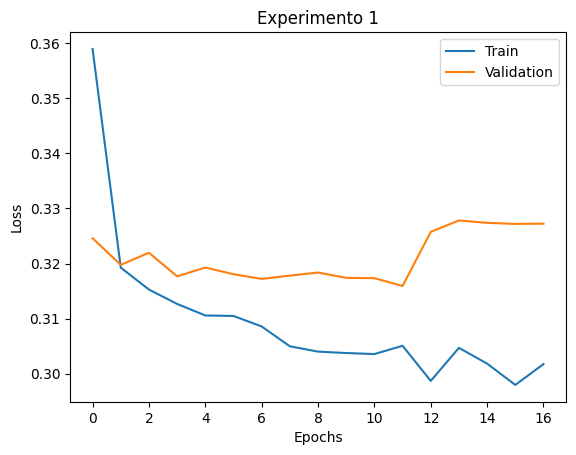


========== Experimento 2 ==========
Epoch 1: Train 0.4320 | Val 0.3340
Epoch 2: Train 0.3462 | Val 0.3233
Epoch 3: Train 0.3330 | Val 0.3200
Epoch 4: Train 0.3315 | Val 0.3196
Epoch 5: Train 0.3273 | Val 0.3194
Epoch 6: Train 0.3256 | Val 0.3196
Epoch 7: Train 0.3235 | Val 0.3188
Epoch 8: Train 0.3213 | Val 0.3212
Epoch 9: Train 0.3228 | Val 0.3188
Epoch 10: Train 0.3228 | Val 0.3190
Epoch 11: Train 0.3193 | Val 0.3188
Epoch 12: Train 0.3222 | Val 0.3186
Epoch 13: Train 0.3191 | Val 0.3186
Epoch 14: Train 0.3179 | Val 0.3186
Epoch 15: Train 0.3187 | Val 0.3188
Epoch 16: Train 0.3160 | Val 0.3186
Epoch 17: Train 0.3208 | Val 0.3193
Epoch 18: Train 0.3165 | Val 0.3185
Epoch 19: Train 0.3162 | Val 0.3180
Epoch 20: Train 0.3160 | Val 0.3180
Epoch 21: Train 0.3185 | Val 0.3177
Epoch 22: Train 0.3168 | Val 0.3189
Epoch 23: Train 0.3161 | Val 0.3175
Epoch 24: Train 0.3141 | Val 0.3180
Epoch 25: Train 0.3182 | Val 0.3179
Epoch 26: Train 0.3135 | Val 0.3175
Epoch 27: Train 0.3153 | Val 0.3174


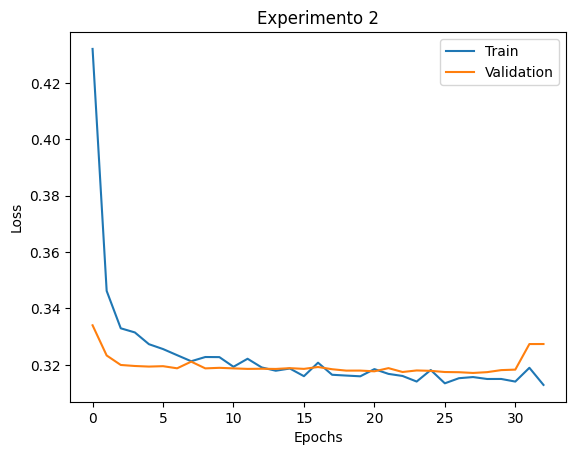


========== Experimento 3 ==========
Epoch 1: Train 0.3557 | Val 0.3248
Epoch 2: Train 0.3193 | Val 0.3190
Epoch 3: Train 0.3171 | Val 0.3214
Epoch 4: Train 0.3142 | Val 0.3185
Epoch 5: Train 0.3109 | Val 0.3178
Epoch 6: Train 0.3095 | Val 0.3170
Epoch 7: Train 0.3098 | Val 0.3166
Epoch 8: Train 0.3064 | Val 0.3203
Epoch 9: Train 0.3090 | Val 0.3259
Epoch 10: Train 0.3118 | Val 0.3254
Epoch 11: Train 0.3072 | Val 0.3284
Epoch 12: Train 0.3041 | Val 0.3271
Early stopping!


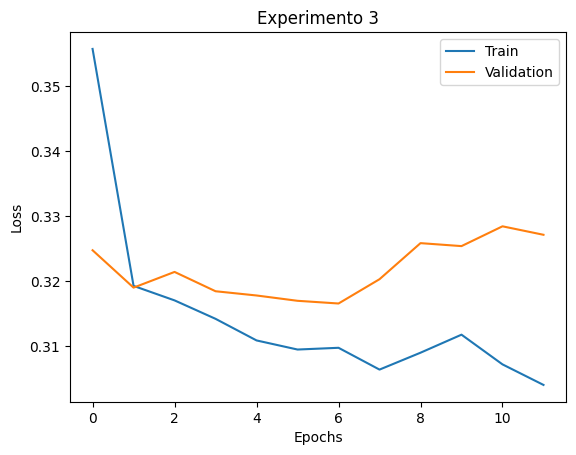


========== Experimento 4 ==========
Epoch 1: Train 0.3487 | Val 0.3209
Epoch 2: Train 0.3143 | Val 0.3192
Epoch 3: Train 0.3091 | Val 0.3175
Epoch 4: Train 0.3070 | Val 0.3185
Epoch 5: Train 0.3050 | Val 0.3185
Epoch 6: Train 0.3032 | Val 0.3189
Epoch 7: Train 0.3022 | Val 0.3178
Epoch 8: Train 0.2997 | Val 0.3170
Epoch 9: Train 0.2983 | Val 0.3156
Epoch 10: Train 0.2979 | Val 0.3185
Epoch 11: Train 0.2959 | Val 0.3186
Epoch 12: Train 0.2950 | Val 0.3175
Epoch 13: Train 0.2960 | Val 0.3174
Epoch 14: Train 0.2910 | Val 0.3188
Early stopping!


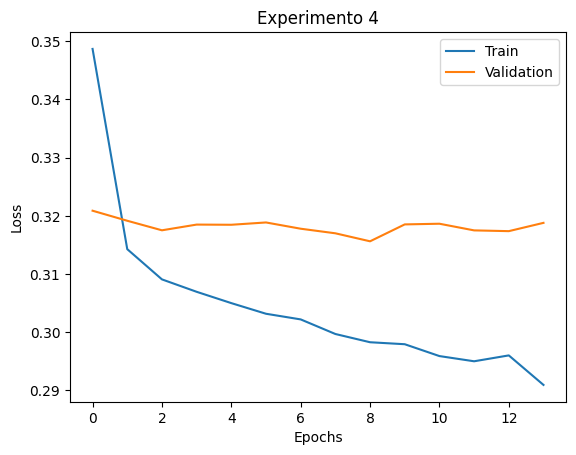


========== Experimento 5 ==========
Epoch 1: Train 0.4860 | Val 0.3564
Epoch 2: Train 0.3792 | Val 0.3326
Epoch 3: Train 0.3634 | Val 0.3248
Epoch 4: Train 0.3526 | Val 0.3214
Epoch 5: Train 0.3481 | Val 0.3202
Epoch 6: Train 0.3460 | Val 0.3204
Epoch 7: Train 0.3409 | Val 0.3196
Epoch 8: Train 0.3430 | Val 0.3199
Epoch 9: Train 0.3428 | Val 0.3196
Epoch 10: Train 0.3395 | Val 0.3194
Epoch 11: Train 0.3398 | Val 0.3196
Epoch 12: Train 0.3431 | Val 0.3200
Epoch 13: Train 0.3451 | Val 0.3191
Epoch 14: Train 0.3394 | Val 0.3188
Epoch 15: Train 0.3357 | Val 0.3195
Epoch 16: Train 0.3414 | Val 0.3191
Epoch 17: Train 0.3416 | Val 0.3203
Epoch 18: Train 0.3363 | Val 0.3200
Epoch 19: Train 0.3361 | Val 0.3190
Early stopping!


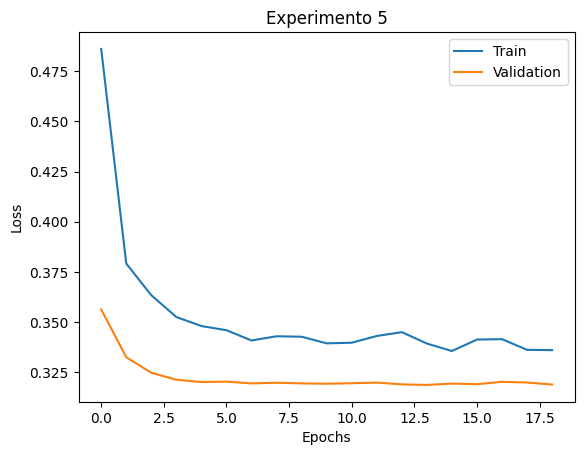

Epoch 1: Train 0.4248 | Val 0.3337
Epoch 2: Train 0.3440 | Val 0.3240
Epoch 3: Train 0.3345 | Val 0.3212
Epoch 4: Train 0.3295 | Val 0.3200
Epoch 5: Train 0.3271 | Val 0.3201
Epoch 6: Train 0.3256 | Val 0.3199
Epoch 7: Train 0.3231 | Val 0.3193
Epoch 8: Train 0.3232 | Val 0.3196
Epoch 9: Train 0.3210 | Val 0.3191
Epoch 10: Train 0.3245 | Val 0.3193
Epoch 11: Train 0.3219 | Val 0.3188
Epoch 12: Train 0.3198 | Val 0.3193
Epoch 13: Train 0.3218 | Val 0.3189
Epoch 14: Train 0.3187 | Val 0.3198
Epoch 15: Train 0.3185 | Val 0.3183
Epoch 16: Train 0.3174 | Val 0.3186
Epoch 17: Train 0.3156 | Val 0.3185
Epoch 18: Train 0.3167 | Val 0.3197
Epoch 19: Train 0.3216 | Val 0.3181
Epoch 20: Train 0.3190 | Val 0.3192
Epoch 21: Train 0.3173 | Val 0.3179
Epoch 22: Train 0.3131 | Val 0.3183
Epoch 23: Train 0.3171 | Val 0.3183
Epoch 24: Train 0.3173 | Val 0.3182
Epoch 25: Train 0.3201 | Val 0.3184
Epoch 26: Train 0.3203 | Val 0.3175
Epoch 27: Train 0.3181 | Val 0.3169
Epoch 28: Train 0.3126 | Val 0.3163
E

In [11]:
# ================================
# 2.2 MODELO DE REDES NEURONALES (MLP)
# ================================

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

# --- 2.2.1 Convertir datos a tensores ---
def to_tensor_dataset(X, y, preprocessor):
    X_proc = preprocessor.transform(X)
    y_bin = y.values.astype(np.float32)
    X_tensor = torch.tensor(
        X_proc.toarray() if hasattr(X_proc, "toarray") else X_proc,
        dtype=torch.float32
    )
    y_tensor = torch.tensor(y_bin, dtype=torch.float32)
    return TensorDataset(X_tensor, y_tensor)

preprocessor.fit(X_train)

train_ds = to_tensor_dataset(X_train, y_train, preprocessor)
val_ds   = to_tensor_dataset(X_val, y_val, preprocessor)
test_ds  = to_tensor_dataset(X_test, y_test, preprocessor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

# --- 2.2.2 Definir arquitectura MLP ---
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=(128,64), dropout=0.5):
        super(MLP, self).__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# --- 2.2.3 Loop de entrenamiento con EarlyStopping ---
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50, patience=5):
    best_loss = np.inf
    patience_counter = 0
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb).squeeze()
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).squeeze()
                loss = criterion(preds, yb)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(f"Epoch {epoch+1}: Train {train_loss:.4f} | Val {val_loss:.4f}")

        # EarlyStopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping!")
                break

    model.load_state_dict(torch.load("best_model.pth"))
    return history

# --- 2.2.4 Experimentos ---
input_dim = train_ds[0][0].shape[0]
criterion = nn.BCELoss()

experimentos = [
    {"hidden_layers": (128,64), "dropout": 0.5, "lr": 0.001, "wd": 0},
    {"hidden_layers": (64,32), "dropout": 0.6, "lr": 0.0005, "wd": 1e-4},
    {"hidden_layers": (256,128,64), "dropout": 0.5, "lr": 0.001, "wd": 1e-4},
    {"hidden_layers": (128,128), "dropout": 0.3, "lr": 0.0007, "wd": 5e-5},
    {"hidden_layers": (64,64,32), "dropout": 0.7, "lr": 0.0005, "wd": 1e-3},
]

historias = []

for i, cfg in enumerate(experimentos, 1):
    print(f"\n========== Experimento {i} ==========")
    model = MLP(input_dim, hidden_layers=cfg["hidden_layers"], dropout=cfg["dropout"]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
    history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50, patience=5)
    historias.append((cfg, history))

    # Graficar pérdidas
    plt.plot(history["train_loss"], label="Train")
    plt.plot(history["val_loss"], label="Validation")
    plt.title(f"Experimento {i}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# --- 2.2.5 Evaluación final ---
def evaluar_modelo(model, loader, nombre="Dataset"):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds = model(xb).squeeze().cpu().numpy()
            y_prob.extend(preds)
            y_pred.extend((preds > 0.5).astype(int))
            y_true.extend(yb.numpy())

    print(f"\n🔹 {nombre}")
    print(classification_report(y_true, y_pred))
    print("AUC:", roc_auc_score(y_true, y_prob))

# Reentrenar el mejor modelo (elige el mejor según tus gráficas/métricas)
best_cfg = experimentos[1]  # Ejemplo: segundo experimento
model = MLP(input_dim, hidden_layers=best_cfg["hidden_layers"], dropout=best_cfg["dropout"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_cfg["lr"], weight_decay=best_cfg["wd"])
train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50, patience=5)

# Evaluar en train/val/test
evaluar_modelo(model, train_loader, "Entrenamiento")
evaluar_modelo(model, val_loader, "Validación")
evaluar_modelo(model, test_loader, "Prueba")
